# Loading Dataset and Annotations

In this notebook we show how to load the data from the StyledCOCO dataset and how to overlay the huma-pose annotations with the images

In [1]:
import os
import sys
import json
from collections import defaultdict
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

sys.path.append("..")

import models
import lib.transforms as custom_transforms
import lib.visualizations as visualizations
import lib.utils as utils
import lib.metrics as metrics
import lib.loss as loss
import lib.nms as nms_lib
import lib.inference as inference
import lib.bounding_box as bbox
import lib.pose_parsing as pose_parsing 
from data import StyledCoco, Coco, HRNetCOCO
from CONFIG import CONFIG

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
test_exp = "test/experiment_2020-06-04_08-06-38"
test_exp = os.path.join(CONFIG["paths"]["experiments_path"], test_exp)

In [4]:
data_path = CONFIG["paths"]["data_path"]
images_path = os.path.join(data_path, "images", "train")
original_imgs_path = os.path.join(data_path, "original_images", "train2017")
labels_path = os.path.join(data_path, "annotations")
labels_file = os.path.join(labels_path, "person_keypoints_train.json")

In [5]:
COCO_KEYPOINT_INDEXES = {
    0: 'nose',
    1: 'left_eye',
    2: 'right_eye',
    3: 'left_ear',
    4: 'right_ear',
    5: 'left_shoulder',
    6: 'right_shoulder',
    7: 'left_elbow',
    8: 'right_elbow',
    9: 'left_wrist',
    10: 'right_wrist',
    11: 'left_hip',
    12: 'right_hip',
    13: 'left_knee',
    14: 'right_knee',
    15: 'left_ankle',
    16: 'right_ankle'
}

# Dataset

In [6]:
normalize = custom_transforms.Normalize(
    mean=[128, 128, 128], std=[256, 256, 256]
)

In [7]:
valid_dataset = HRNetCOCO(root=data_path, img_path=original_imgs_path,
                          labels_path=labels_file, 
                          is_train=False,
                          transform=transforms.Compose([
                              normalize,
                              transforms.ToTensor(),
                          ])
)

Heatmap size: [48 64]
loading annotations into memory...
Done (t=10.84s)
creating index...
index created!


In [8]:
valid_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=2,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

random_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=2,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )

In [9]:
# imgs, target, target_weight, meta = next(iter(valid_loader))
imgs, target, target_weight, meta = next(iter(random_loader))

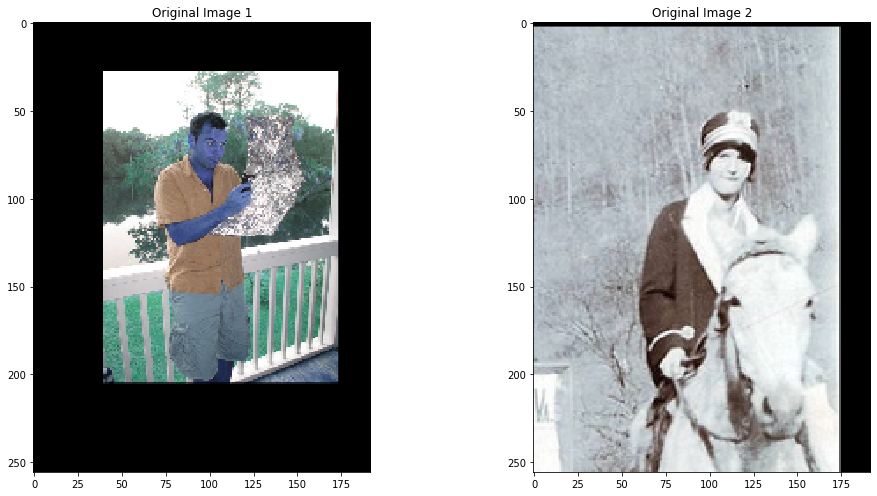

In [10]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(15,7)
visualizations.visualize_image(np.array(imgs[0,:]), ax=ax[0], title="Original Image 1")
visualizations.visualize_image(np.array(imgs[1,:]), ax=ax[1], title="Original Image 2")
plt.tight_layout()
plt.show()

# Models

In [11]:
faster_rcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [12]:
# HRNet Model
hrnet = models.PoseHighResolutionNet(is_train=False)
pretrained_path = os.path.join(CONFIG["paths"]["pretrained_path"], "HRnet", "pose_hrnet_w32_256x192.pth")
hrnet.load_state_dict(torch.load(pretrained_path))

<All keys matched successfully>

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
faster_rcnn = faster_rcnn.to(device)
hrnet = hrnet.to(device)
faster_rcnn = faster_rcnn.eval()
hrnet = hrnet.eval()

# Inference

In [14]:
class PersonMSELoss(nn.Module):
    """
    Loss function used for training Top-down approaches (loss after human detector)
    """

    def __init__(self, use_target_weight=1):
        """
        Initializer of the loss module
        """

        super(PersonMSELoss, self).__init__()
        self.criterion = nn.MSELoss(reduction='mean')
        self.use_target_weight = use_target_weight

        return


    def forward(self, output, target, target_weight=1):
        """
        Computing the average loss value accross all joints
        """

        batch_size = output.shape[0]
        num_joints = output.shape[1]
        heatmaps_pred = output.reshape((batch_size, num_joints, -1)).split(1, 1)
        heatmaps_gt = target.reshape((batch_size, num_joints, -1)).split(1, 1)
        loss = 0

        for idx in range(num_joints):
            heatmap_pred = heatmaps_pred[idx].squeeze()
            heatmap_gt = heatmaps_gt[idx].squeeze()
            loss += 0.5 * self.criterion(heatmap_pred, heatmap_gt)

        avg_loss = loss / num_joints

        return avg_loss

In [15]:
output = hrnet(imgs.to(device).float())

In [16]:
target = target.cuda(non_blocking=True)
target_weight = target_weight.cuda(non_blocking=True)

In [17]:
loss_function = PersonMSELoss()
loss_value = loss_function(output, target, target_weight).item()
print(f"Loss Value: {round(loss_value,5)}")

Loss Value: 0.00046


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

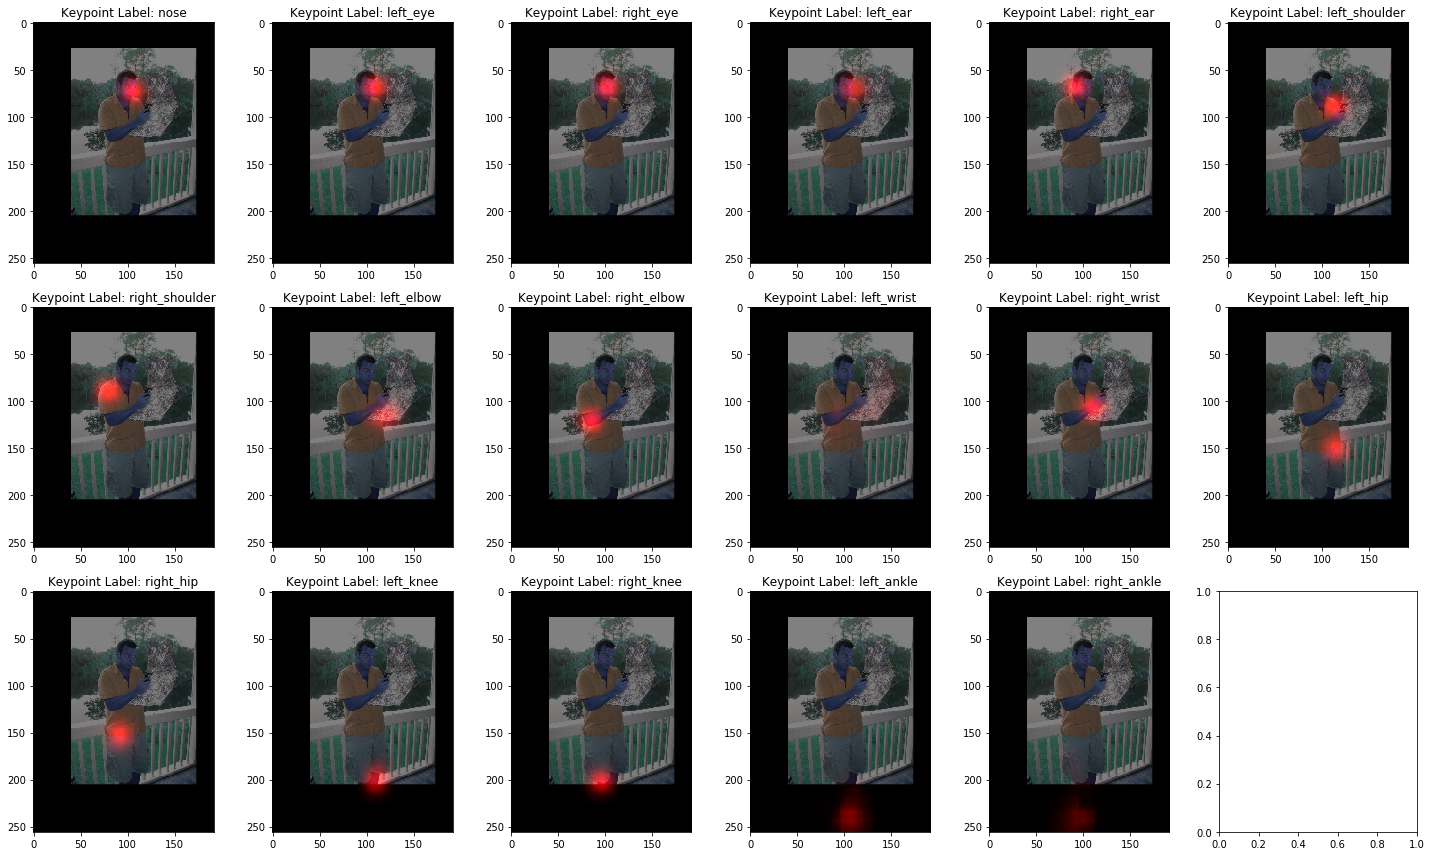

In [18]:
idx = 0
fig, ax = plt.subplots(3,6)
fig.set_size_inches(20,12)
scaled_heats = F.interpolate(output.clone().detach(), (256, 192), mode="bilinear",
                             align_corners=True)
for i in range(17):
    row = i // 6
    col = i% 6
    title = f"Keypoint Label: {COCO_KEYPOINT_INDEXES[i]}"
    visualizations.overlay_heatmap(heatmap=np.array(scaled_heats[idx,i,:].cpu()), img=np.array(imgs[idx,:].cpu()),
                                   ax=ax[row, col], title=title)
plt.tight_layout()
plt.show()

In [19]:

def get_max_preds(batch_heatmaps):
    '''
    get predictions from score maps
    heatmaps: numpy.ndarray([batch_size, num_joints, height, width])
    '''
    
    assert isinstance(batch_heatmaps, np.ndarray), \
        'batch_heatmaps should be numpy.ndarray'
    assert batch_heatmaps.ndim == 4, 'batch_images should be 4-ndim'

    batch_size = batch_heatmaps.shape[0]
    num_joints = batch_heatmaps.shape[1]
    width = batch_heatmaps.shape[3]
    heatmaps_reshaped = batch_heatmaps.reshape((batch_size, num_joints, -1))
    idx = np.argmax(heatmaps_reshaped, 2)
    maxvals = np.amax(heatmaps_reshaped, 2)

    maxvals = maxvals.reshape((batch_size, num_joints, 1))
    idx = idx.reshape((batch_size, num_joints, 1))

    preds = np.tile(idx, (1, 1, 2)).astype(np.float32)

    preds[:, :, 0] = (preds[:, :, 0]) % width
    preds[:, :, 1] = np.floor((preds[:, :, 1]) / width)

    pred_mask = np.tile(np.greater(maxvals, 0.0), (1, 1, 2))
    pred_mask = pred_mask.astype(np.float32)

    preds *= pred_mask
    
    return preds, maxvals


def get_final_preds(batch_heatmaps, center, scale):
    """
    """
    
    coords, maxvals = get_max_preds(batch_heatmaps)

    heatmap_height = batch_heatmaps.shape[2]
    heatmap_width = batch_heatmaps.shape[3]

    # post-processing
#     if config.TEST.POST_PROCESS:
    for n in range(coords.shape[0]):
        for p in range(coords.shape[1]):
            hm = batch_heatmaps[n][p]
            px = int(np.floor(coords[n][p][0] + 0.5))
            py = int(np.floor(coords[n][p][1] + 0.5))
            if 1 < px < heatmap_width-1 and 1 < py < heatmap_height-1:
                diff = np.array(
                    [
                        hm[py][px+1] - hm[py][px-1],
                        hm[py+1][px]-hm[py-1][px]
                    ]
                )
                coords[n][p] += np.sign(diff) * .25

    preds = coords.copy()

    # Transform back
    for i in range(coords.shape[0]):
        preds[i] = custom_transforms.transform_preds(
            coords[i], center[i], scale[i], [heatmap_width, heatmap_height]
        )

    return preds, maxvals

In [20]:
my_keypoints, my_max_vals = pose_parsing.get_max_preds_hrnet(scaled_heats.cpu().numpy(), thr=0.1)

centers = meta["center"].numpy()
scales = meta["scale"].numpy()
score = meta["score"].numpy()

keypoints, max_vals = get_final_preds(scaled_heats.cpu().numpy(), centers, scales)

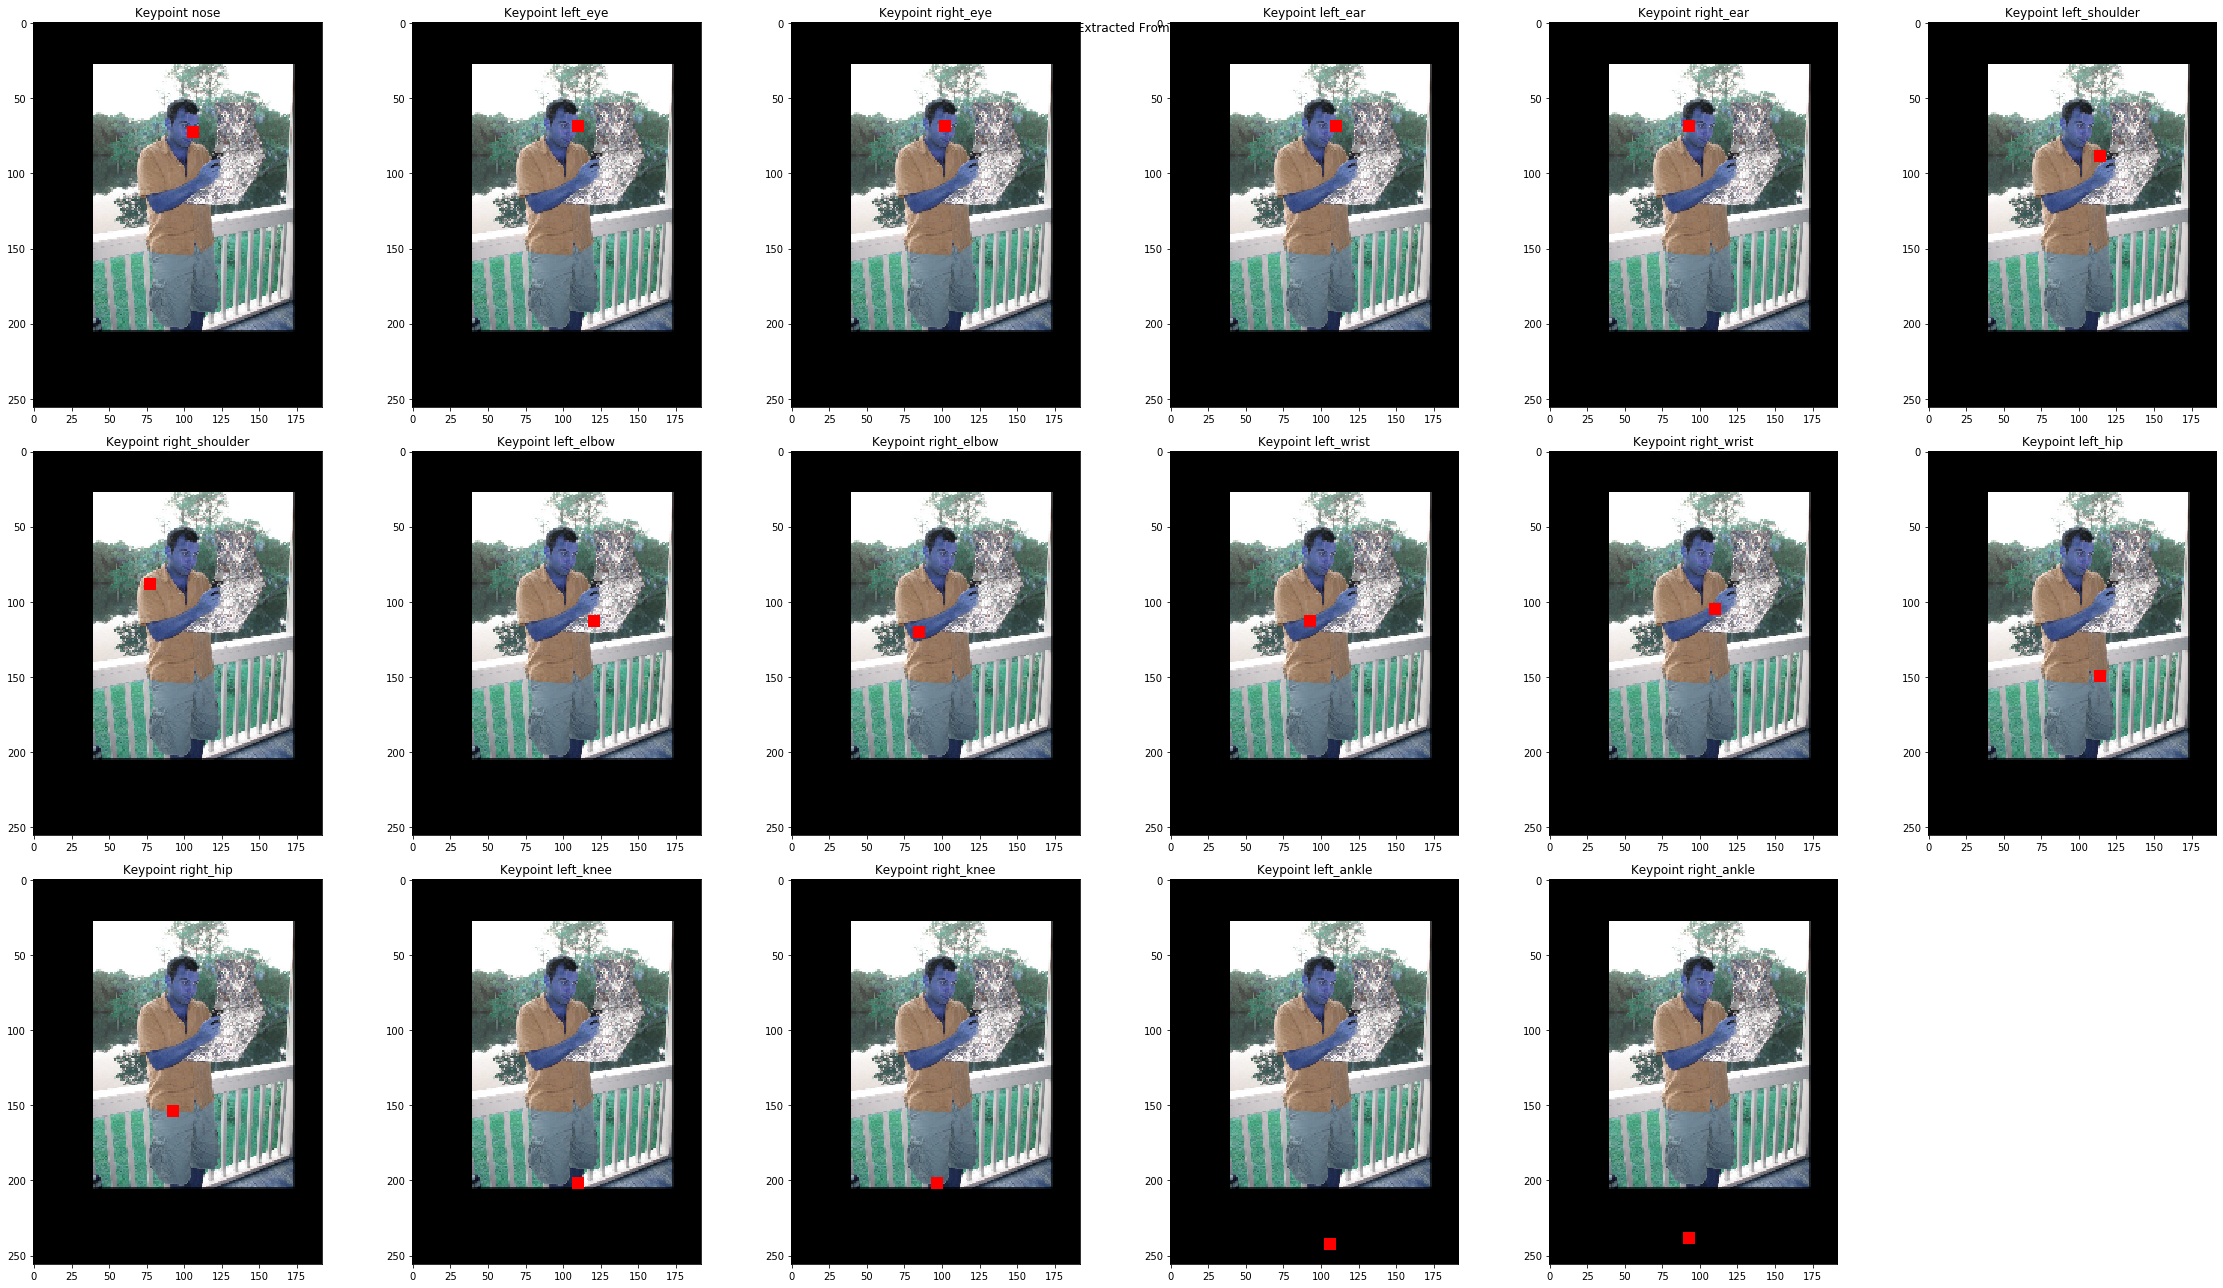

In [21]:
idx = 0
plt.figure(figsize=(32, 18))
zoom = 4

cur_img = np.array(imgs[idx,:].cpu())
aux_img = np.array([cur_img[2,:,:], cur_img[1,:,:], cur_img[0,:,:]])
aux_img = np.copy(aux_img).transpose(1,2,0)*256 + 128
aux_img = np.round(aux_img).astype(int)

for i, k in enumerate(my_keypoints[idx]):
    
    aux = np.copy(aux_img)
    if(len(k) > 0):
        aux[k[0]-zoom:k[0]+zoom, k[1]-zoom:k[1]+zoom,0] = 255
        aux[k[0]-zoom:k[0]+zoom, k[1]-zoom:k[1]+zoom,1] = 0
        aux[k[0]-zoom:k[0]+zoom, k[1]-zoom:k[1]+zoom,2] = 0
    
    plt.subplot(3,6,i+1)
    plt.imshow(aux)
    plt.title(f"Keypoint {COCO_KEYPOINT_INDEXES[i]}")
    
plt.suptitle("Joints Extracted From Dets")
plt.tight_layout()
plt.show()

In [22]:
# saving predictions
all_preds = np.zeros((2, 17, 3), dtype=np.float32)
all_preds[:,:,:2] = keypoints[:,:,:2]
all_preds[:,:,2:3] = max_vals

In [23]:
# saving bounding boxes
all_boxes = np.zeros((2, 6))
all_boxes[:, 0:2] = centers[:, 0:2]
all_boxes[:, 2:4] = scales[:, 0:2]
all_boxes[:, 4] = np.prod(scales*200, 1)
all_boxes[:, 5] = score

In [24]:
data_path = CONFIG["paths"]["data_path"]
labels_path = os.path.join(data_path, "annotations")
# labels_file = os.path.join(labels_path, "person_keypoints_validation.json")
labels_file = os.path.join(labels_path, "person_keypoints_train.json")

preds_file = os.path.join(test_exp, CONFIG["paths"]["submission"])

In [25]:
kpts_per_person = []
for idx, kpt in enumerate(all_preds):
    kpts_per_person.append({
        'keypoints': kpt,
        'center': all_boxes[idx][0:2],
        'scale': all_boxes[idx][2:4],
        'area': all_boxes[idx][4],
        'score': all_boxes[idx][5],
        'image': int(meta["image"][idx][-16:-4])
    })

In [26]:
# image x person x (keypoints)
kpts_per_img = defaultdict(list)
for kpt in kpts_per_person:
    kpts_per_img[kpt['image']].append(kpt)

In [27]:
def write_coco_keypoint_results(keypoints, res_file):
    """
    """
    
    data_pack =  {
        'cat_id': 1,
        'cls_ind': 1,
        'cls': 1,
        'ann_type': 'keypoints',
        'keypoints': keypoints
    }
    results = coco_keypoint_results_one_category_kernel(data_pack)
    
    with open(res_file, 'w') as f:
        json.dump(results, f)
        
    return

In [28]:
def coco_keypoint_results_one_category_kernel(data_pack):
    """
    """
    
    cat_id = data_pack['cat_id']
    keypoints = data_pack['keypoints']
    cat_results = []
    
    for img_kpts in keypoints:
        if len(img_kpts) == 0:
            continue

        _key_points = np.array([img_kpts[k]['keypoints']
                                for k in range(len(img_kpts))])
        key_points = np.zeros(
            (_key_points.shape[0], 17 * 3), dtype=np.float
        )

        for ipt in range(17):
            key_points[:, ipt * 3 + 0] = _key_points[:, ipt, 0]
            key_points[:, ipt * 3 + 1] = _key_points[:, ipt, 1]
            key_points[:, ipt * 3 + 2] = _key_points[:, ipt, 2]  # keypoints score.

        result = [
            {
                'image_id': img_kpts[k]['image'],
                'category_id': cat_id,
                'keypoints': list(key_points[k]),
                'score': img_kpts[k]['score'],
                'center': list(img_kpts[k]['center']),
                'scale': list(img_kpts[k]['scale'])
            }
            for k in range(len(img_kpts))
        ]
        cat_results.extend(result)

    return cat_results

In [29]:
# rescoring and oks nms
num_joints = 7
in_vis_thr = 0.2
oks_thr = 0.9 
oks_nmsed_kpts = []

for img in kpts_per_img.keys():
    img_kpts = kpts_per_img[img]
    for person_data in img_kpts:
        box_score = person_data['score']
        kpt_score = 0
        valid_num = 0
        for n_joint in range(0, num_joints):
            joint_score = person_data['keypoints'][n_joint][2]
            if joint_score > in_vis_thr:
                kpt_score = kpt_score + joint_score
                valid_num = valid_num + 1
        if valid_num != 0:
            kpt_score = kpt_score / valid_num
        # rescoring
        person_data['score'] = kpt_score * box_score
        
    keep = nms_lib.oks_nms([img_kpts[i] for i in range(len(img_kpts))], oks_thr) 
    
    if len(keep) == 0:
        oks_nmsed_kpts.append(img_kpts)
    else:
        oks_nmsed_kpts.append([img_kpts[k] for k in keep])

utils.reset_predictions_file(test_exp)
write_coco_keypoint_results(oks_nmsed_kpts, preds_file)

In [30]:
stats = metrics.compute_precision(labels_file=labels_file, preds_file=preds_file)

loading annotations into memory...
Done (t=10.04s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.498
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.663
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.663
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = 0.700
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.404
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.500
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.667
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.667
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | m

<div class=alert style="background-color:#F5F5F5; border-color:#C8C8C8">
   This notebook was created by <b>Angel Villar-Corrales</b>
</div> 